<a href="https://colab.research.google.com/github/SiddarthSamdani/SkimLit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SkimLit** 📄🔥
In the previous notebook (NLP fundamentals in TensorFlow), we went through some fundamental natural lanuage processing concepts. The main ones being tokenzation (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

#### **Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

#### **Solution in a sentence**
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

📖 **Resources**: Before going through the code in this notebook, we want to get a background of what we're going to be doing.

Where our data is coming from: PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts

Where our model is coming from: Neural networks for joint sentence classification in medical paper abstracts.

#### **What we're going to cover**
Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

Downloading a text dataset (PubMed RCT200k from GitHub)

Writing a preprocessing function to prepare our data for modelling

Setting up a series of modelling experiments

Making a baseline (TF-IDF classifier)

Deep models with different combinations of: token embeddings, character 
embeddings, pretrained embeddings, positional embeddings

Building our first multimodal model (taking multiple types of data inputs)

Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf

Find the most wrong predictions

Making predictions on PubMed abstracts from the wild



### **Access to a GPU**
Since we're going to be building deep learning models, let's make sure we have a GPU.

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b6b70d42-212c-fdc2-909e-9ef74533a79d)


# **Get data**
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Checking the contents of the downloaded repository, we can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:

PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.

PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).

Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, we will use 7-Zip on Windows.

To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.

Let's check the file contents.

In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:

**train.txt** - training samples.

**dev.txt** - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).

**test.txt** - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# **Preprocess data**


To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

Alright, we've got a little function, **get_lines()** which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data **(train.txt)**.

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:

Take a target file of abstract samples.

Read the lines in the target file.

For each line in the target file:

If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.

Keep count of the number of lines in a sample.

If the line begins with \n mark it as the end of an abstract sample.

Keep count of the total lines in a sample.

Record the text before the \t as the label of the line.

Record the text after the \t as the text of the line.

Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:

**"line_number"** - the position of the line in the abstract (e.g. 3).

**"target"** - the role of the line in the abstract (e.g. OBJECTIVE).

**"text"** - the text of the line in the abstract.

**"total_lines"** - the total lines in an abstract sample (e.g. 14).

Abstract ID's and newlines should be omitted from the returned preprocessed data.

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

       # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

Beautiful! That's one good looking function. Let's use it to preprocess each of our RCT 20k datasets.

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 938 ms, sys: 121 ms, total: 1.06 s
Wall time: 1.63 s


How do our training samples look?

In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Fantastic! Looks like our **preprocess_text_with_line_numbers()** function worked great.

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our data is in DataFrame form, we can perform some data analysis on it.

In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Looks like sentences with the OBJECTIVE label are the least common.

How about we check the distribution of our abstract lengths?

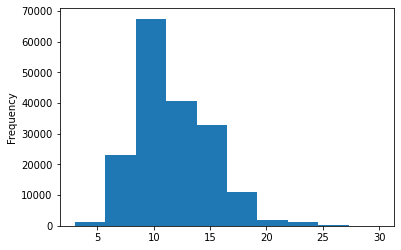

In [13]:
  train_df.total_lines.plot.hist();

Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

## **Get lists of sentences**

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [14]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Alright, we've separated our text samples.We'll have to write code to convert the text to numbers before we can use it with our machine learning models, we'll get to this soon.

### **Make numeric labels (ML models require numeric labels)**

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### **Label encode labels**

In [17]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

Now we've trained an instance of **LabelEncoder**, we can get the class names and number of classes using the **classes_** attribute.

In [18]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## **Creating a series of model experiments**
We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

## **Model 0: Getting a baseline**

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn **Pipeline** which uses the **TfidfVectorizer** class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the **MultinomialNB** aglorithm.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

Due to the speed of the Multinomial Naive Bayes algorithm, it trains very quickly.

We can evaluate our model's accuracy on the validation dataset using the **score()** method.

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [21]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the **calculate_results()** function from **helper_functions.py** script to compare them to the ground truth labels.

More specificially the **calculate_results()** function will help us obtain the following:

Accuracy

Precision

Recall

F1-score

### **Download helper functions script**
Let's get our **helper_functions.py** script.

In [22]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-12 15:31:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-12 15:31:49 (49.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Now we've got the helper functions script we can import the caculate_results() function and see how our baseline model went

In [23]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## **Preparing our data for deep sequence models**
Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

How about the distribution of sentence lengths?

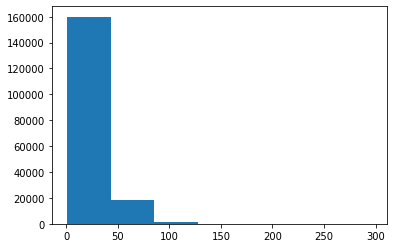

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's **percentile** to find the value which covers 95% of the sentence lengths.

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

🤔 Question: Why 95%?

We could use the max sentence length of the sentences in the training set.

In [29]:
# Maximum sentence length in the training set
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

## **Create text vectorizer**
Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [30]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [31]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

Great! Looks like our **text_vectorizer** is ready, let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
to examine safety , tolerability , and efficacy of pf-@ , an inhibitor of the receptor for advanced glycation end products ( rage ) , in mild to moderate alzheimer disease ( ad ) .

Length of text: 35

Vectorized text:
[[    6   534   136   833     3    79     4  3847    26   738     4     2
    746    11   588 12639   199  1703 28909     5   533     6   362  2730
    114  1246     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Cool, we've now got a way to turn our sequences into numbers.

Using the **get_vocabulary()** method of our **text_vectorizer** we can find out a few different tidbits about our text.

In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


And if we wanted to figure out the configuration of our **text_vectorizer** we can use the **get_config()** method.

In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## **Create custom text embedding**

Our **token_vectorization** layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's **Embedding** layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our **Embedding** layer.

The **input_dim** parameter defines the size of our vocabulary. And the **output_dim** parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our **text_vectorization** layer as inputs and convert them to feature vectors of size **output_dim**.

Let's see it in action.



In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
to examine safety , tolerability , and efficacy of pf-@ , an inhibitor of the receptor for advanced glycation end products ( rage ) , in mild to moderate alzheimer disease ( ad ) .

Sentence after vectorization (before embedding):
[[    6   534   136   833     3    79     4  3847    26   738     4     2
    746    11   588 12639   199  1703 28909     5   533     6   362  2730
    114  1246     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04941965  0.00143988 -0.0310958  ... -0.03450518  0.02948361
    0.00312637]
  [ 0.03224876  0.02869852 -0.01524854 ... -0.00139204 -0.02843735
    0.03345502]
  [-0.04958797  0.04452661 -0.01378398 ...  0.02322688 -0.02392384
    0.01359569]
  ...
  [-0.03808173  0.04201511  0.02129778 ... -0.04910015 -0.02143236
    0.01410443]
  [-0.03808173  0.04201511  0.0

## **Create datasets (as fast as possible)**
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the **tf.data** API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a **PrefetchDataset** of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched **PrefetchDataset** we can use the methods **batch()** and **prefetch()**, the parameter **tf.data.AUTOTUNE** will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# **Model 1: Conv1D with token embeddings**
Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

Build model

Train model

Evaluate model (make predictions and compare to ground truth)

In [39]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, we notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the **output_dim** parameter of the **Embedding** layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [41]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 17s 14ms/step - loss: 0.9263 - accuracy: 0.6332 - val_loss: 0.6835 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6519 - accuracy: 0.7592 - val_loss: 0.6296 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6126 - accuracy: 0.7770 - val_loss: 0.5957 - val_accuracy: 0.7876


Brilliant! We've got our first trained deep sequence model, and it didn't take too long (and if we didn't prefetch our batched data, it would've taken longer).

Time to make some predictions with our model and then evaluate them.

In [42]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.5938 - accuracy: 0.7872


[0.5938438177108765, 0.7872368693351746]

In [43]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.67983305e-01, 1.36192650e-01, 6.43660203e-02, 3.11151624e-01,
        2.03063414e-02],
       [4.27265078e-01, 2.87214279e-01, 1.43401418e-02, 2.61412710e-01,
        9.76781081e-03],
       [1.48280710e-01, 7.33907009e-03, 1.28481106e-03, 8.43059897e-01,
        3.54789627e-05],
       ...,
       [7.21860579e-06, 7.02825899e-04, 5.34256571e-04, 4.93239804e-06,
        9.98750806e-01],
       [5.26709110e-02, 4.28897679e-01, 1.23571046e-01, 6.38938546e-02,
        3.30966502e-01],
       [1.58139467e-01, 7.39800930e-01, 3.49874981e-02, 3.57181951e-02,
        3.13539393e-02]], dtype=float32)

In [44]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.72368595260161,
 'f1': 0.7847658115633459,
 'precision': 0.7842764574469854,
 'recall': 0.7872368595260162}

## **Model 2: Feature extraction with pretrained token embeddings**
Training our own embeddings took a little while to run, slowing our experiments down.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

We notice the lack of tokenization layer we've used in a previous model. This is because the **Universal Sentence Encoder (USE)** takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

To download the pretrained USE into a layer we can use in our model, we can use the hub.KerasLayer class.

We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

🔑 Note: Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Beautiful, now our pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence.

In [47]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the study of heart and renal protection ( sharp ) randomized patients with ckd to @ mg simvastatin plus @ mg ezetimibe daily versus matching placebo .

Sentence after embedding:
[-0.02224663 -0.01785053 -0.0646194  -0.01928337  0.0567033  -0.02363413
 -0.01578841 -0.01552969  0.01533692 -0.00546991  0.08539129 -0.05426889
  0.02849527  0.01197738  0.01076547  0.01349718 -0.08562237 -0.06488328
  0.01438592 -0.04284655  0.07099571  0.02967367  0.01822051 -0.02820119
  0.06225332 -0.06440962  0.06159241  0.03935015 -0.00465898 -0.00242518] (truncated output)...

Length of sentence embedding:
512


Nice! As we mentioned before the pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

Let's put together and compile a model using our tf_hub_embedding_layer.

### **Building and fitting an NLP feature extraction model from TensorFlow Hub**

In [48]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set **training=False** when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [50]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9186 - accuracy: 0.6486 - val_loss: 0.7978 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7700 - accuracy: 0.7003 - val_loss: 0.7568 - val_accuracy: 0.6998
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7546 - accuracy: 0.7100 - val_loss: 0.7420 - val_accuracy: 0.7144


In [51]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7436 - accuracy: 0.7131


[0.7436454892158508, 0.7131272554397583]

Since we aren't training our own custom embedding layer, training is much quicker.

Let's make some predictions and evaluate our feature extraction model.

In [52]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4364381e-01, 3.5055685e-01, 2.4883552e-03, 1.9639653e-01,
        6.9144811e-03],
       [3.6464280e-01, 4.6526861e-01, 3.5345843e-03, 1.6356577e-01,
        2.9882644e-03],
       [2.3943910e-01, 1.6081838e-01, 1.6329734e-02, 5.4401910e-01,
        3.9393641e-02],
       ...,
       [1.8323491e-03, 6.8585170e-03, 5.5542916e-02, 8.9329289e-04,
        9.3487293e-01],
       [4.1725496e-03, 4.7111649e-02, 1.8664989e-01, 1.3064628e-03,
        7.6075947e-01],
       [1.7653692e-01, 2.5200665e-01, 4.9820083e-01, 7.8712925e-03,
        6.5384328e-02]], dtype=float32)

In [53]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.31272342115716,
 'f1': 0.7100935823501404,
 'precision': 0.713456878139093,
 'recall': 0.7131272342115715}

# **Model 3: Conv1D with character embeddings**
### **Creating a character-level tokenizer**

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the **TextVectorization** class and then passing those vectorized sequences through an **Embedding** layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [55]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e   s t u d y   o f   h e a r t   a n d   r e n a l   p r o t e c t i o n   (   s h a r p   )   r a n d o m i z e d   p a t i e n t s   w i t h   c k d   t o   @   m g   s i m v a s t a t i n   p l u s   @   m g   e z e t i m i b e   d a i l y   v e r s u s   m a t c h i n g   p l a c e b o   .'

Great! Looks like our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [56]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [57]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

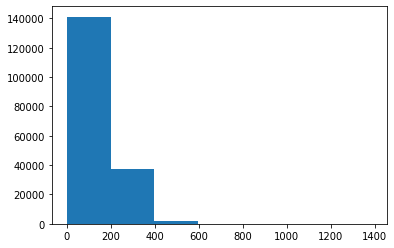

In [58]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

Okay, looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences.

In [59]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our **TextVectorization** layer as the **output_sequence_length** parameter.

We'll set **max_tokens** (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [60]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Nice! Now we've adapted our **char_vectorizer** to our character-level sequences, let's check out some characteristics about it using the **get_vocabulary()** method.

In [62]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


We can also test it on random sequences of characters to make sure it's working.

In [63]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   i n t r a g r o u p   a n a l y s i s   o v e r   t h e   t i m e   o f   t h e   t r e a t m e n t   s h o w e d   i m p r o v e m e n t s   i n   t h e   f i e l d s   o f   d e s i r e   ,   l u b r i c a t i o n   ,   a n d   r e d u c e d   p a i n   f o r   p o l y a c r y l i c   a c i d   ,   t e s t o s t e r o n e   ,   a n d   e s t r o g e n   .

Length of chars: 154

Vectorized chars:
[[ 3 13  2  4  6  3  8  5 18  8  7 16 14  5  6  5 12 19  9  4  9  7 21  2
   8  3 13  2  3  4 15  2  7 17  3 13  2  3  8  2  5  3 15  2  6  3  9 13
   7 20  2 10  4 15 14  8  7 21  2 15  2  6  3  9  4  6  3 13  2 17  4  2
  12 10  9  7 17 10  2  9  4  8  2 12 16 22  8  4 11  5  3  4  7  6  5  6
  10  8  2 10 16 11  2 10 14  5  4  6 17  7  8 14  7 12 19  5 11  8 19 12
   4 11  5 11  4 10  3  2  9  3  7  9  3  2  8  7  6  2  5  6 10  2  9  3
   8  7 18  2  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

We notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the **standardize** parameter of **TextVectorization** being **"lower_and_strip_punctuation"** and the split parameter being **"whitespace"** by default, symbols (such as @) and spaces are removed.

## **Creating a character-level embedding**
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the **tensorflow.keras.layers.Embedding** class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (**input_dim**) will be equal to the number of different characters in our **char_vocab** (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (**output_dim**) will be 25.

In [64]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   i n t r a g r o u p   a n a l y s i s   o v e r   t h e   t i m e   o f   t h e   t r e a t m e n t   s h o w e d   i m p r o v e m e n t s   i n   t h e   f i e l d s   o f   d e s i r e   ,   l u b r i c a t i o n   ,   a n d   r e d u c e d   p a i n   f o r   p o l y a c r y l i c   a c i d   ,   t e s t o s t e r o n e   ,   a n d   e s t r o g e n   .

Embedded chars (after vectorization and embedding):
[[[ 0.04733639  0.04810751 -0.01437013 ... -0.00960075  0.01642302
    0.02894907]
  [-0.02259598  0.02634777 -0.0138268  ... -0.0030089   0.03578552
    0.01447033]
  [-0.00820531  0.04122125  0.00082331 ...  0.0468404  -0.02937945
    0.02968306]
  ...
  [ 0.04678002 -0.03663019 -0.04909259 ... -0.03366784 -0.01688212
    0.00472962]
  [ 0.04678002 -0.03663019 -0.04909259 ... -0.03366784 -0.01688212
    0.00472962]
  [ 0.04678002 -0.03663019 -0.04909259 ... -0.03366784 -0.01688212
    0.00472962]]]

Character embedding

Wonderful! Each of the characters in our sequences gets turned into a 25 dimension embedding.

## **Building a Conv1D model to fit on character embeddings**
Now we've got a way to turn our character-level sequences into numbers (**char_vectorizer**) as well as numerically represent them as an embedding (**char_embed**) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (**model_1**) except it'll take character-level sequences as input instead of token-level sequences.

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [65]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched **PrefetchedDataset**'s.

In [67]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

Just like our token-level sequence model, to save time with our experiments, we'll fit the character-level model on 10% of batches.

In [68]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2572 - accuracy: 0.4957 - val_loss: 1.0442 - val_accuracy: 0.5861
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0080 - accuracy: 0.5958 - val_loss: 0.9458 - val_accuracy: 0.6273
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9329 - accuracy: 0.6345 - val_loss: 0.8742 - val_accuracy: 0.6652


In [69]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8985 - accuracy: 0.6499


[0.8984948992729187, 0.649874210357666]

Nice! Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [70]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2111249 , 0.4851531 , 0.06545337, 0.19095854, 0.04731013],
       [0.18447515, 0.5261372 , 0.0152437 , 0.23740982, 0.03673411],
       [0.10022584, 0.4430489 , 0.13963239, 0.26661825, 0.05047465],
       ...,
       [0.03659961, 0.03672488, 0.16132258, 0.01650817, 0.74884474],
       [0.014472  , 0.14121795, 0.28686327, 0.03830533, 0.51914144],
       [0.5141153 , 0.24456304, 0.17825864, 0.05162683, 0.01143617]],
      dtype=float32)

In [71]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [72]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.98742221633788,
 'f1': 0.639673875139132,
 'precision': 0.6493103764482829,
 'recall': 0.6498742221633788}

# **Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)**
Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model, we're going to go through the following steps:

Create a token-level model (similar to **model_1**)

Create a character-level model (similar to **model_3** with a slight modification to reflect the paper)

Combine (using **layers.Concatenate**) the outputs of 1 and 2

Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [73]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

Woah... There's a lot going on here, let's get a summary and plot our model to visualize what's happening.

In [74]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

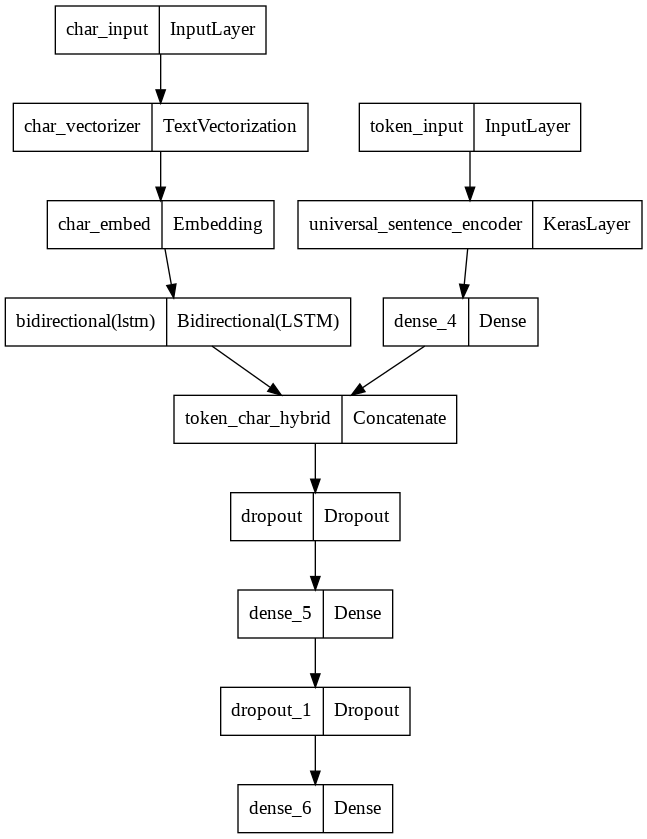

In [75]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4) 

Now that's a good looking model. Let's compile it just as we have the rest of our models.

In [76]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a **tf.data.Dataset** with a tuple as it's first input, for example:

**((token_data, char_data), (label))**

Let's see it in action.

## **Combining token and character data into a tf.data dataset**

In [77]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

## **Fitting a model on token and character-level sequences**

In [79]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 121ms/step - loss: 0.9653 - accuracy: 0.6181 - val_loss: 0.7748 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.7925 - accuracy: 0.6937 - val_loss: 0.7231 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 66s 117ms/step - loss: 0.7742 - accuracy: 0.6997 - val_loss: 0.6914 - val_accuracy: 0.7344


In [80]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.6935 - accuracy: 0.7325


[0.6935221552848816, 0.7324572801589966]

Nice! Our token-character hybrid model has come to life!

To make predictions with it, since it takes multiplie inputs, we can pass the **predict()** method a tuple of token-level sequences and character-level sequences.

We can then evaluate the predictions as we've done before.

In [81]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2567962e-01, 3.4963506e-01, 4.3427167e-03, 2.0889902e-01,
        1.1443629e-02],
       [4.5406032e-01, 3.5215437e-01, 2.3518244e-03, 1.8974775e-01,
        1.6857791e-03],
       [2.8701836e-01, 1.4667027e-01, 3.6085974e-02, 4.9591321e-01,
        3.4312226e-02],
       ...,
       [3.5513652e-04, 5.6314552e-03, 5.4356739e-02, 1.3009421e-04,
        9.3952656e-01],
       [5.3579947e-03, 4.5537930e-02, 2.7854210e-01, 2.3832326e-03,
        6.6817874e-01],
       [4.0039796e-01, 3.1519479e-01, 2.1946421e-01, 4.0359400e-02,
        2.4583619e-02]], dtype=float32)

In [82]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 0])>

In [83]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.24573017344102,
 'f1': 0.7303538035780612,
 'precision': 0.732875726255636,
 'recall': 0.7324573017344101}

# **Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**
It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying our own knowledge to build features as input to a model is called feature engineering.

Can we think of something important about the sequences we're trying to classify?

If we were to look at an abstract, would we expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beginning and sequences labelled OBJECTIVE at the end?

We can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

Sentence 1 of 10 ...

Sentence 2 of 10 ...

Sentence 3 of 10 ...

Sentence 4 of 10 ...

...

We have noticed this when we created our **preprocess_text_with_line_numbers()** function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the **"line_number"** and **"total_lines"** columns of our DataFrames.

In [84]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The **"line_number"** and **"total_lines"** columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

## **Create positional embeddings**
Okay, enough talk about positional embeddings, let's create them.

Since our **"line_number"** and **"total_line"** columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with **"line_number"=5** is five times greater than a line with **"line_number"=1**, we'll use one-hot-encoding to encode our **"line_number"** and **"total_lines"** features.

To do this, we can use the **tf.one_hot** utility.

**tf.one_hot** returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the **depth** parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the **"line_number"** column.

🔑 **Note:** When it comes to one-hot-encoding our features, Scikit-Learn's **OneHotEncoder** class is another viable option here.

In [85]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

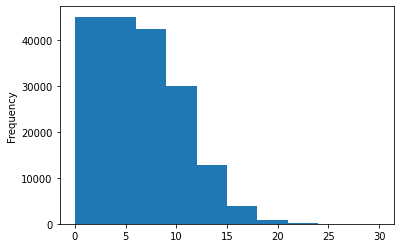

In [86]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the **"line_number"** column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the **depth** parameter of **tf.one_hot** to 15.

In [87]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the **depth** parameter of **tf.one_hot** to 15 means any sample with a **"line_number"** value of over 15 gets set to a tensor of all 0's, where as any sample with a **"line_number"** of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the **"line_number"** value.

🔑 **Note:** We could create a one-hot tensor which has room for all of the potential values of **"line_number" (depth=30)**, however, this would end up in a tensor of double the size of our current one **(depth=15)** where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a **"line_number"** value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the curse of dimensionality. 

In [88]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

We can do the same as we've done for our **"line_number"** column with the **"total_lines"** column. First, let's find an appropriate value for the **depth** parameter of **tf.one_hot**.

In [89]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

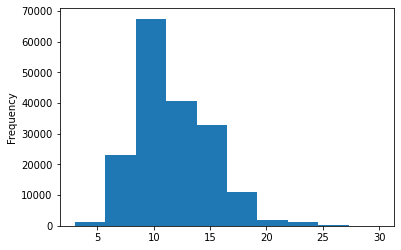

In [90]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our **"total_lines"** column, a value of 20 looks like it covers the majority of samples.

We can confirm this with **np.percentile()**.

In [91]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

Beautiful! Plenty of coverage. Let's one-hot-encode our **"total_lines"** column just as we did our **"line_number"** column.

In [92]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## **Building a tribrid embedding model**
Positional embedding tensors ready.

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here we haven't practiced before.

More specifically we're going to go through the following steps:

Create a token-level model (similar to **model_1**)

Create a character-level model (similar to **model_3** with a slight modification to reflect the paper)

Create a **"line_number"** model (takes in one-hot-encoded **"line_number"** tensor and passes it through a non-linear layer)

Create a **"total_lines"** model (takes in one-hot-encoded **"total_lines"** tensor and passes it through a non-linear layer)

Combine (using **layers.Concatenate**) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

Combine (using **layers.Concatenate**) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding

Create an output layer to accept the tribrid embedding and output predicted label probabilities

Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a **tf.keras.Model**

Woah! That's alot... but nothing we're not capable of. Let's code it.

In [93]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

There's a lot going on here... let's visualize what's happening with a summary by plotting our model.

In [94]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

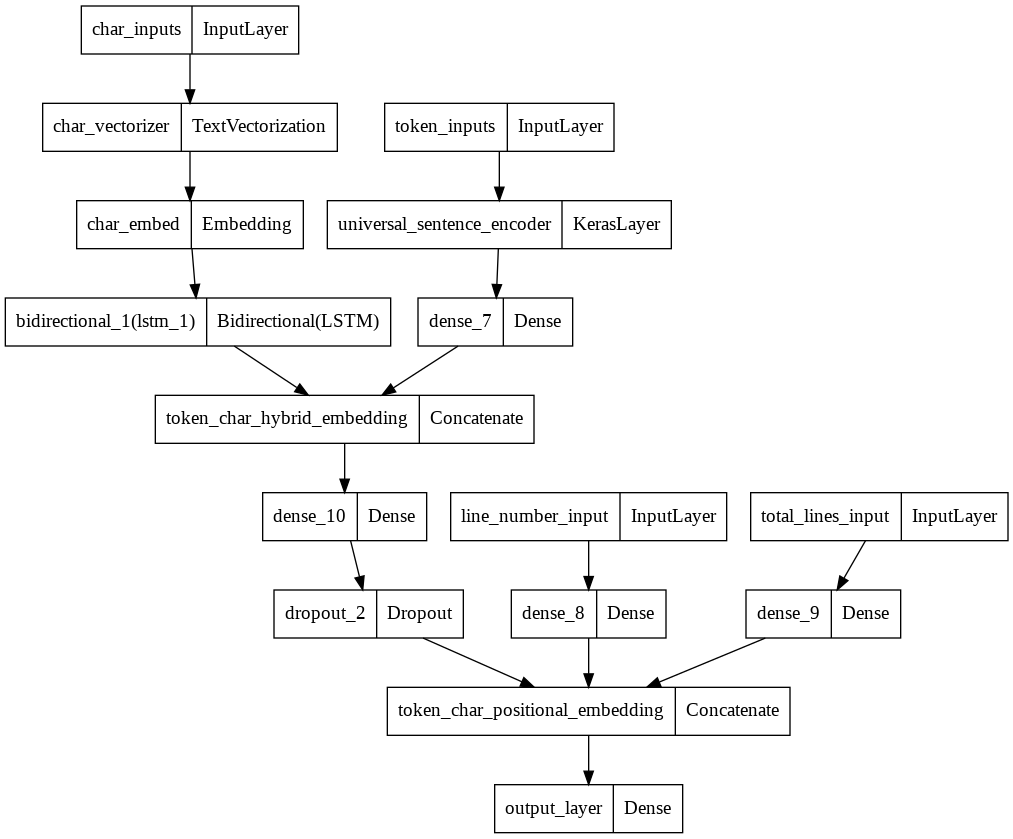

In [95]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Visualizing the model makes it much easier to understand.

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

In [96]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe0db6b1c50> True
<keras.engine.input_layer.InputLayer object at 0x7fe0db7649d0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fe0ee08e290> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fe16ac6b090> False
<keras.layers.embeddings.Embedding object at 0x7fe0ee0645d0> True
<keras.layers.core.dense.Dense object at 0x7fe168f77350> True
<keras.layers.wrappers.Bidirectional object at 0x7fe0db678410> True
<keras.layers.merge.Concatenate object at 0x7fe0db5fbad0> True
<keras.engine.input_layer.InputLayer object at 0x7fe0db5fba90> True
<keras.engine.input_layer.InputLayer object at 0x7fe168f45c10> True
<keras.layers.core.dense.Dense object at 0x7fe0db56b510> True
<keras.layers.core.dense.Dense object at 0x7fe0db697cd0> True
<keras.layers.core.dense.Dense object at 0x7fe0db5ed750> True
<keras.layers.core.dropout.Dropout object at 0x7fe0db5c0110> True
<keras.layers.merge.Concatenate object at 0x7fe0db

Now our model is constructed, let's compile it.

This time, we're going to introduce a new parameter to our loss function called **label_smoothing**. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

**[0.0, 0.0, 1.0, 0.0, 0.0]** for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:

**[0.01, 0.01, 0.096, 0.01, 0.01]** giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [97]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## **Create tribrid embedding datasets and fit tribrid model**
Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

Train line numbers one-hot tensor (**train_line_numbers_one_hot**)

Train total lines one-hot tensor (**train_total_lines_one_hot**)

Token-level sequences tensor (**train_sentences**)

Char-level sequences tensor (**train_chars**)

We can pass these as tuples to our **tf.data.Dataset.from_tensor_slices()** method to create appropriately shaped and batched **PrefetchedDataset**'s.

In [98]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [99]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 122ms/step - loss: 1.1020 - accuracy: 0.7201 - val_loss: 0.9862 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9705 - accuracy: 0.8133 - val_loss: 0.9529 - val_accuracy: 0.8251
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9539 - accuracy: 0.8217 - val_loss: 0.9423 - val_accuracy: 0.8271


Tribrid model trained! Time to make some predictions with it and evaluate them just as we've done before.

In [100]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 50s 51ms/step


array([[0.5009481 , 0.10723075, 0.01310492, 0.36137363, 0.01734265],
       [0.5427524 , 0.11130813, 0.03572414, 0.3002822 , 0.00993319],
       [0.30771637, 0.09725147, 0.1359207 , 0.38828346, 0.07082796],
       ...,
       [0.03881039, 0.08416232, 0.03901591, 0.03269094, 0.80532044],
       [0.03071022, 0.28420886, 0.08697609, 0.02780586, 0.5702989 ],
       [0.20705087, 0.525753  , 0.14888287, 0.04354944, 0.07476383]],
      dtype=float32)

In [101]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [102]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.23513835562028,
 'f1': 0.8312379610558377,
 'precision': 0.8315504853094834,
 'recall': 0.8323513835562029}

## **Compare model results**
Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [103]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.723686,0.784276,0.787237,0.784766
pretrained_token_embed,71.312723,0.713457,0.713127,0.710094
custom_char_embed_conv1d,64.987422,0.649310,0.649874,0.639674
hybrid_char_token_embed,73.245730,0.732876,0.732457,0.730354
tribrid_pos_char_token_embed,83.235138,0.831550,0.832351,0.831238


In [104]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

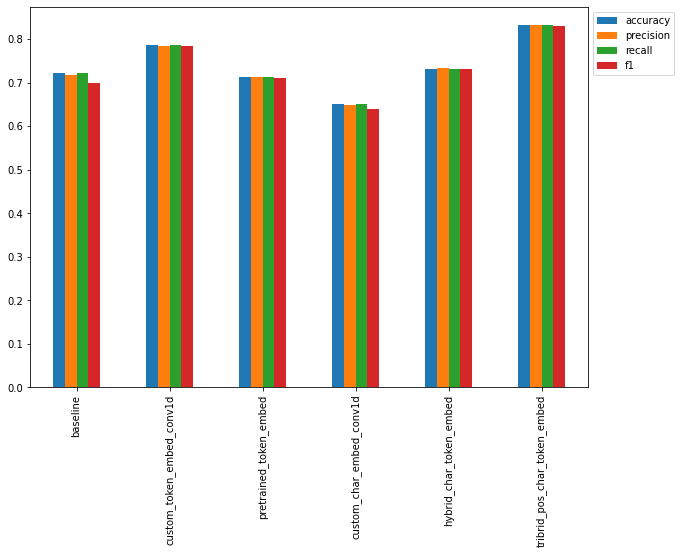

In [105]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper compares their tested model's F1-scores on the test dataset, let's take a look at our model's F1-scores.

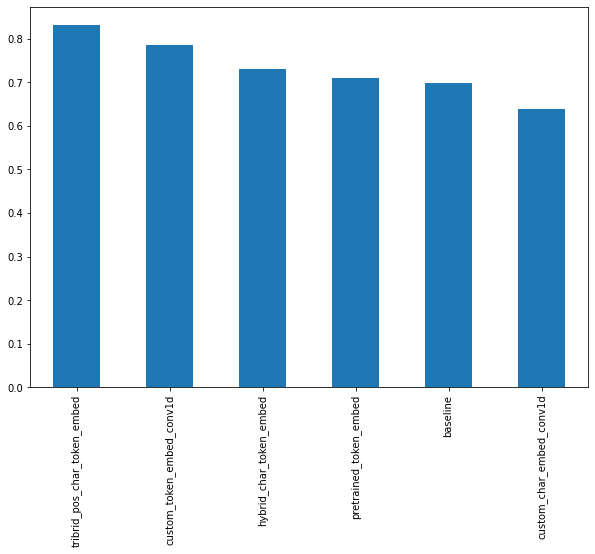

In [106]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Nice! Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:

Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.

This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).

Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).
## **Save and load best performing model**
Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the **save()** method on it.

In [107]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


Copying saved model to Google Drive

In [108]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skim_lit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

Like all good cooking shows, we've got a pretrained model (exactly the same kind of model we built for **model_5** saved and stored on Google Storage).

We'll download it and load it in.

And when loading in our model, since it uses a couple of custom objects (our TensorFlow Hub layer and **TextVectorization** layer), we'll have to load it in by specifying them in the **custom_objects** parameter of **tf.keras.models.load_model()**.

In [109]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-02-12 15:45:35--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  50.0MB/s    in 8.4s    

2022-02-12 15:45:44 (110 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_

In [110]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

AssertionError: ignored

## **Make predictions and evalaute them against the truth labels**
To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

Now let's compare our loaded model's predictions with the prediction results we obtained before saving our model.

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

It's worth noting that loading in a **SavedModel** unfreezes all layers (makes them all trainable). So if you want to freeze any layers, you'll have to set their **trainable** attribute to **False**.

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

## **Evaluate model on test dataset**
To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset.

## **Find most wrong**
One of the best ways to investigate where our model is going wrong (or potentially where our data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

Now we'll enrich our test DataFame with a few values:

A "prediction" (string) column containing our model's prediction for a given sample.

A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.

A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

Looking good! Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest **"pred_prob"** and where the prediction was wrong **("correct" == False)**?

In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

Great (or not so great)! Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

What do you notice about the most wrong predictions? Does the model make silly mistakes? Or are some of the labels incorrect/ambiguous (e.g. a line in an abstract could potentially be labelled **OBJECTIVE** or **BACKGROUND** and make sense).

A next step here would be if there are a fair few samples with inconsistent labels, you could go through your training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.

## **Make example predictions**
Okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed we see many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

Following is an unstructured abstract from RCT of a manualized social treatment for high-functioning autism spectrum disorders:

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine what happens when a medical researcher tries to skim through the literature to find a study relevant to his work.

Sounds like quite the challenge right?   

Enter SkimLit 🤓🔥!

Let's see what our best model so far **(model_5)** makes of the above abstract.

But wait...

The above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.

Starting with number 1, there are a couple of ways to split our abstracts into actual sentences. A simple one would be to use Python's in-built **split()** string method, splitting the abstract wherever a fullstop appears. 

Another more advanced option would be to leverage spaCy's (a very powerful NLP library) **sentencizer** class. Which is an easy to use sentence splitter based on spaCy's English language model.

We can download some abstracts from PubMed RCT papers to try our model on them, from GitHub.

In [ ]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts  

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

Now we've downloaded some example abstracts, let's see how one of them goes with our trained model.

First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences

In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

Beautiful! It looks like spaCy has split the sentences in the abstract correctly. 

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

To do so, we can leverage some of the functionality of our **preprocess_text_with_line_numbers()** function.

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

Now we've got **"line_number"** and **"total_lines"** values, we can one-hot encode them with **tf.one_hot** just like we did with our training dataset (using the same values for the **depth** parameter).

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

We can also use our **split_chars()** function to split our abstract lines into characters.

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

Alright, now we've preprocessed our wild RCT abstract into all of the same features our model was trained on, we can pass these features to our model and make sequence label predictions!

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

Now we've got the predicted sequence label for each line in our sample abstract, let's write some code to visualize each sentence with its predicted label.

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

Nice! Isn't that much easier to read? I mean, it looks like our model's predictions could be improved, but how cool is that?

Imagine implementing our model to the backend of the PubMed website to format any unstructured RCT abstract on the site.

Or there could even be a browser extension, called "SkimLit" which would add structure (powered by our model) to any unstructured RCT abtract.

And if showed to any of our medical researcher friend, and they thought the predictions weren't up to standard, there could be a button saying "is this label correct?... if not, what should it be?". That way the dataset, along with our model's future predictions, could be improved over time.

Of course, there are many more ways we could go to improve the model, the usuability, the preprocessing functionality (e.g. functionizing our sample abstract preprocessing pipeline).